In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
import matplotlib.pyplot as plt

2023-04-20 00:12:37.552008: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#reads a file. Each line has the format: label text
#Returns a list with the text and a list with the labels
def readData(fname):

    with open(fname, 'r', encoding="utf-8") as f:
        fileData = f.read()
  
    lines = fileData.split("\n")
    textData = list()
    textLabel = list()
    lineLength = np.zeros(len(lines))
    
    for i, aLine in enumerate(lines):     
        if not aLine:
            break  
        label = aLine.split(" ")[0]
        lineLength[i] = len(aLine.split(" "))
        if(label == "__label__1"):
            textLabel.append(0)
            textData.append(aLine.removeprefix("__label__1 "))

        elif(label == "__label__2"):
            textLabel.append(1)
            textData.append(aLine.removeprefix("__label__2 "))

        else:
            print("\nError in readData: ", i, aLine)
            exit()
    
    f.close()
    return textData, textLabel, int(np.average(lineLength)+2*np.std(lineLength))

In [4]:
def transformData(x_train, y_train, x_test, y_test, maxFeatures, seqLength):
    #transforms text input to int input based on the vocabulary
    #max_tokens = maxFeatures is the size of the vocabulary
    #output_sequence_length =  seqLength is the maximum length of the transformed text. Adds 0 is text length is shorter
    precLayer = layers.experimental.preprocessing.TextVectorization(max_tokens = maxFeatures, 
    standardize =  'lower_and_strip_punctuation', split = 'whitespace', output_mode = 'int', 
    output_sequence_length =  seqLength)
    precLayer.adapt(x_train)
    #print(precLayer.get_vocabulary())
    x_train_int = precLayer(x_train)
    y_train = tf.convert_to_tensor(y_train)
    #print(x_train_int)
    #print(y_train)
    x_test_int= precLayer(x_test)
    y_test = tf.convert_to_tensor(y_test)
    #print(x_test_int)
    #print(y_test)

    return x_train_int, y_train, x_test_int, y_test

In [5]:
x_train, y_train, seqLength = readData("data/amazon/train_small.txt")
x_test, y_test, tmp = readData("data/amazon/test_small.txt")

#maxFeatures is a hyperparameter
maxFeatures = 10000

x_train_int, y_train, x_test_int, y_test = transformData(x_train, y_train, x_test, y_test, 
maxFeatures, seqLength)

2023-04-20 00:12:48.036810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 00:12:48.039924: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


# Dataset
Now we check the distribution of the classes, in order to know if we need to apply any balancing techniques. We will not delve into the language difference, as the solution to it isn't very clear. 
- We could detect and translate the minority language to the majority one, that way the model would have more samples of the same language anmd thus would learn better, but that would remove its capability of understanding the minority language.
- We could also translate all text to both languages, increasing the overall samples of each language, thus improving the model, but this would imply using pre-existing language models to identify the samples' language and translate it, thus kinda defeating the purpose of this practical assignment.

Number of training examples for label 0:  12117
Number of training examples for label 1:  12883
Number of test examples for label 0:  12157
Number of test examples for label 1:  12843


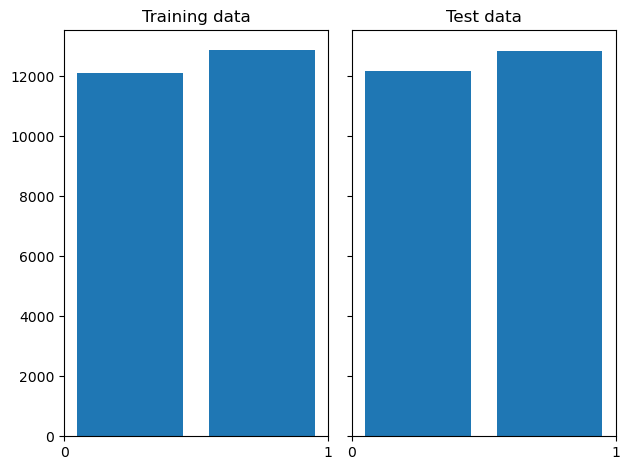

In [6]:
# Create a plot that contains two subplots, one for the distribution of labels of the training data and one for the test data
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# Plot the distribution of labels of the training data
axs[0].hist(y_train, bins=2, rwidth=0.8)
# Add a title to the first subplot
axs[0].set_title('Training data')
# Label the x-axis of the first subplot with each label
axs[0].set_xticks([0, 1])

# Plot the distribution of labels of the test data
axs[1].hist(y_test, bins=2, rwidth=0.8)
# Add a title to the second subplot
axs[1].set_title('Test data')
# Label the x-axis of the first subplot with each label
axs[1].set_xticks([0, 1])

# Print the number of training examples and the number of test examples for each label
print("Number of training examples for label 0: ", np.sum(y_train == 0))
print("Number of training examples for label 1: ", np.sum(y_train == 1))
print("Number of test examples for label 0: ", np.sum(y_test == 0))
print("Number of test examples for label 1: ", np.sum(y_test == 1))

As shown by the plots, there is no need to perform any dataset balancing, as the labels are divided almost evenly

# Architecture

As proven in the previous practical assignment, Bidirectional LSTMs were the best performing architecture, so even though this is a compeltely different problem, they give us an indication on which model to try first.

In [ ]:
model = Sequential()

model.add(layers.Embedding(maxFeatures, 40, input_length=seqLength))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))

model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 166, 40)           400000    
                                                                 
 bidirectional (Bidirectiona  (None, 40)               9760      
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 41        
                                                                 
Total params: 409,801
Trainable params: 409,801
Non-trainable params: 0
_________________________________________________________________


In [12]:
callbacks = [
    keras.callbacks.ModelCheckpoint("modelsAmazon/bidirectionallstm.keras", monitor='val_loss', save_best_only=True)
]

history = model.fit(x_train_int, y_train, epochs=70,validation_data=(x_test_int, y_test),callbacks=callbacks)

Epoch 1/70
782/782 [==============================] - 275s 345ms/step - loss: 0.4260 - accuracy: 0.8034 - val_loss: 0.3082 - val_accuracy: 0.8709
Epoch 2/70
782/782 [==============================] - 273s 349ms/step - loss: 0.2699 - accuracy: 0.8931 - val_loss: 0.2723 - val_accuracy: 0.8882
Epoch 3/70
782/782 [==============================] - 254s 325ms/step - loss: 0.2428 - accuracy: 0.9042 - val_loss: 0.3052 - val_accuracy: 0.8772
Epoch 4/70
782/782 [==============================] - 229s 293ms/step - loss: 0.2242 - accuracy: 0.9126 - val_loss: 0.3125 - val_accuracy: 0.8808
Epoch 5/70
782/782 [==============================] - 267s 341ms/step - loss: 0.2140 - accuracy: 0.9182 - val_loss: 0.2756 - val_accuracy: 0.8866
Epoch 6/70
782/782 [==============================] - 279s 357ms/step - loss: 0.2026 - accuracy: 0.9240 - val_loss: 0.2895 - val_accuracy: 0.8921
Epoch 7/70
782/782 [==============================] - 283s 362ms/step - loss: 0.1950 - accuracy: 0.9270 - val_loss: 0.2663 -

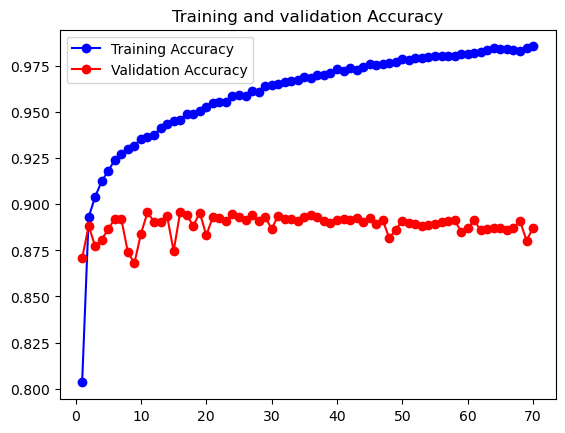

Highers validation accuracy:  0.8957200050354004


In [14]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training Accuracy")
plt.plot(epochs, val_loss, "r-o", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

print("Highers validation accuracy: ", max(val_loss))

# Bidirectional2

In [21]:
model = Sequential()

model.add(layers.Embedding(maxFeatures, 40, input_length=seqLength))
model.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6)))

model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])


model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 166, 40)           400000    
                                                                 
 bidirectional_7 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 41        
                                                                 
Total params: 409,801
Trainable params: 409,801
Non-trainable params: 0
_________________________________________________________________


In [22]:
callbacks = [
    keras.callbacks.ModelCheckpoint("modelsAmazon/bidirectionallstm.keras", monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=8)
]

history = model.fit(x_train_int, y_train, epochs=50,validation_data=(x_test_int, y_test),callbacks=callbacks)

Epoch 1/50
782/782 [==============================] - 187s 235ms/step - loss: 0.3940 - accuracy: 0.8191 - val_loss: 0.2936 - val_accuracy: 0.8792
Epoch 2/50
782/782 [==============================] - 200s 256ms/step - loss: 0.2314 - accuracy: 0.9105 - val_loss: 0.2770 - val_accuracy: 0.8874
Epoch 3/50
782/782 [==============================] - 216s 277ms/step - loss: 0.1913 - accuracy: 0.9286 - val_loss: 0.3162 - val_accuracy: 0.8807
Epoch 4/50
782/782 [==============================] - 206s 264ms/step - loss: 0.1678 - accuracy: 0.9368 - val_loss: 0.2999 - val_accuracy: 0.8883
Epoch 5/50
782/782 [==============================] - 205s 262ms/step - loss: 0.1440 - accuracy: 0.9462 - val_loss: 0.2993 - val_accuracy: 0.8835
Epoch 6/50
782/782 [==============================] - 210s 268ms/step - loss: 0.1276 - accuracy: 0.9523 - val_loss: 0.3319 - val_accuracy: 0.8807
Epoch 7/50
782/782 [==============================] - 207s 265ms/step - loss: 0.1167 - accuracy: 0.9564 - val_loss: 0.3460 -

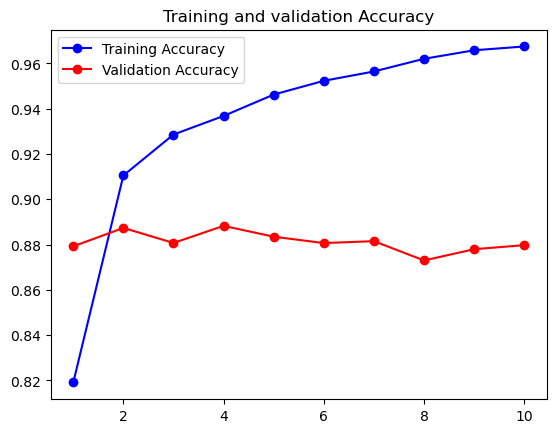

Highers validation accuracy:  0.8882799744606018


In [26]:
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, "b-o", label="Training Accuracy")
plt.plot(epochs, val_loss, "r-o", label="Validation Accuracy")
plt.title("Training and validation Accuracy")
plt.legend()
plt.show()

print("Highers validation accuracy: ", max(val_loss))